# Label engineering

### Description
In this notebook we create labels based on loan payments. We define the problem of predicting default as a binary classification problem, with a temporal component, where the label is *"at a given prediction date (current date when model gets called), is a given loan likely to default within the next N months?"*.

In order to solve that problem, we use each loan's historical data to build ground truth labels for each given `loan_id` and `prediction_date` combination: For example, if `N=12`, we will build data multiple data points for a given loan `L00000001`, one per `prediction_date`.

- We define "default" by a **delinquency of 90+ days**. This definition can be adjusted by changing the parameter `DEFAULT_DEFINITION`.
- We sample data points every month, which can also be controlled by the parameter `PREDICTION_DATE_FREQUENCY`.

### Notes about the data and assumptions
In this dataset, payments are made every 12th of the month. The actual date is not important, but the code does rely on the fact that payments are made on a given recurring date: if a payment is missed on February 12th, we assume that this month's payments were skipped completely and that the next payment will occur on March 12th.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br>**

### High level parameters

In [1]:
DEFAULT_DEFINITION = 90 # in days
PREDICTION_DATE_FREQUENCY = 1 # in months
PREDICTION_WINDOW_LENGTH = 12 # in months
MIN_PREDICTION_DATE = '2014-01-31' # note: this should start late enough to observe default in the next PREDICTION_WINDOW_LENGTH months for the first batch of loans
MAX_PREDICTION_DATE = '2017-12-31' # note: this date should leave enough months a head for a full prediction window of length PREDICTION_WINDOW_LENGTH
PURPOSES = 'all' # either 'all' or a list of purposes to filter, e.g. ['home', 'debt_consolidation']

### Check parameters

In [2]:
if not isinstance(DEFAULT_DEFINITION, int):
    raise Exception('Parameter DEFAULT_DEFINITION must be an integer.')
if not isinstance(PREDICTION_DATE_FREQUENCY, int):
    raise Exception('Parameter PREDICTION_DATE_FREQUENCY must be an integer.')
if not isinstance(PREDICTION_WINDOW_LENGTH, int):
    raise Exception('Parameter PREDICTION_WINDOW_LENGTH must be an integer.')
if not (isinstance(PURPOSES, list) or PURPOSES == 'all'):
    raise Exception('Parameter PURPOSES must be either a list or a string equal to `all`.')

import pandas as pd
try:
    pd.to_datetime(MIN_PREDICTION_DATE), pd.to_datetime(MAX_PREDICTION_DATE)
except Exception:
    raise Exception('MIN_PREDICTION_DATE or MAX_PREDICTION_DATE not in a date format compatible with pandas.')

# 0. Load packages and data

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import project_lib
project = project_lib.Project()

In [4]:
loan = pd.read_csv(project.get_file('loan.csv'), parse_dates=['loan_start_date'])
trans = pd.read_csv(project.get_file('trans.csv'), parse_dates=['transaction_date'])

# 1. Detect default

## 1.1 Extract loan payments from transaction table

In [5]:
loan_payments = trans.loc[trans['tx_type_3'] == "Loan Payment", ['account_id', 'transaction_date', 'amount']]
loan_payments.rename(columns={'transaction_date': 'payment_date'}, inplace=True)
loan_payments.head()

account_id payment_date  amount
6210   A00001801   2013-07-12  4610.0
8787   A00001843   2013-08-12  2938.7
8838   A00001801   2013-08-12  4610.0
8863   A00009188   2013-08-12  2118.3
11931  A00011013   2013-09-12  4579.0

## 1.2 Filter loan purposes

In [6]:
loan = loan[loan['loan_purpose'].str.match('|'.join(PURPOSES) if PURPOSES != 'all' else '.*')]
loan.shape

(682, 7)

## 1.3 Join with loans to get start and end date of each loan

In [7]:
lp_joined = pd.merge(loan, loan_payments, on='account_id')
print(loan_payments.shape)
print(lp_joined.shape)
lp_joined.head()

(13580, 3)
(13580, 9)


loan_id account_id  loan_principal  loan_duration  loan_payments  \
0  L00005657  A00003354            4980             12            415   
1  L00005657  A00003354            4980             12            415   
2  L00005657  A00003354            4980             12            415   
3  L00005657  A00003354            4980             12            415   
4  L00005657  A00003354            4980             12            415   

  loan_start_date loan_purpose payment_date  amount  
0      2014-07-05          car   2014-07-12   415.0  
1      2014-07-05          car   2014-08-12   415.0  
2      2014-07-05          car   2014-09-12   415.0  
3      2014-07-05          car   2014-10-12   415.0  
4      2014-07-05          car   2014-11-12   415.0

## 1.4 Get additional info for each month

### Implementation note:

The operations done here are based on the fact that pandas preserves the order after a `groupby` operation: if we sort by date first, then group by account, rows will still be ordered by date within each group.

### Notes about the data

In this dataset, some loans have minor discrepencies in the payments that lead to a fully paid loan within 1% of the actual principal (i.e. payments can add up to 99% or 101% of principal). We consider the loan to be fully paid if the sum of amounts paid is within 1% of the total loan amount.

In [8]:
lp_joined.sort_values('payment_date', inplace=True)

lp_joined['time_since_last_payment'] = lp_joined.groupby('account_id')['payment_date'].diff(periods=1)
lp_joined['time_until_next_payment'] = -lp_joined.groupby('account_id')['payment_date'].diff(periods=-1)

lp_joined = pd.merge(lp_joined, lp_joined.groupby('account_id')['payment_date'].first().to_frame('date_of_first_payment').reset_index())

lp_joined['late_payment'] = lp_joined['time_since_last_payment'].dt.days > 31

lp_joined['sum_payments_to_date'] = lp_joined.groupby('account_id')['amount'].cumsum()

# fix small data quality issue in the public dataset
lp_joined['payment_number'] = lp_joined.groupby('account_id')['amount'].cumcount() + 1
lp_joined = lp_joined[lp_joined['payment_number'] <= lp_joined['loan_duration']]
lp_joined.drop(columns=['payment_number'], inplace=True)

# allow 1% difference
lp_joined['loan_paid_off'] = ((lp_joined['sum_payments_to_date'] - lp_joined['loan_principal']).abs()/lp_joined['loan_principal']) <= 0.01

## 1.5 Determine date of default

Loans that default are defined as:
- at at least one given date of payment:
    - loan is not paid off yet
    - time until next payment is > 1 month + N days where `N = DEFAULT_DEFINITION`

The reason for the last bullet point is that a delinquency period starts once a payment is missed: If for example the last payment observed is on January 12th, the first missed payment is on February 12th which is the start of the delinquency period. Hence, if we use the standard definition of default, 90 days delinquency, that hypothetical loan would default on May 12th, 1 month + 90 days after the last payment observed.

In [9]:
def loan_default(row, delinquency_duration=90):
    """
    For each payment row, determine if loan defaults within next 1 month + `delinquency_duration` days.
    Note this could be simplified but is left as is for clarity.
    
    This function assumes that payments are made once per month, at a given date (e.g. 12th of the month).
    This function assumes that for each payment, there is enough observed months ahead to have time to observe default,
    which will depend on whether this notebook's high level parameters are set correctly.
    """
    result = pd.Series({'loan_id': row['loan_id'],
                        'account_id': row['account_id'],
                        'current_date': row['payment_date'],
                        'date_of_first_payment': row['date_of_first_payment'],
                        'default': None,
                        'date_of_default': None})
    
    if row['loan_paid_off']:
        # case 1: easy, loan paid off => hasn't defaulted
        result['default'], result['date_of_default'] = False, pd.NaT
    else:
        if pd.isnull(row['time_until_next_payment']):
            # case 2: this payment is the last payment observed for this loan
            # the next payment was missed, which means the next payment's expected date is when the loan becomes delinquent
            # hence date of default is the next payment's date + the duration of delinquency allowed by the bank.
            date_of_expected_next_payment = row['payment_date'].date() + pd.Timedelta(1, 'M')
            result['default'], result['date_of_default'] = True, pd.to_datetime(date_of_expected_next_payment + pd.Timedelta(delinquency_duration, 'd'))
        else:
            # case 3: this payment is not the last payment observed for this loan
            if row['time_until_next_payment'].days > delinquency_duration + 30:
                # case 3.1: client did eventually pay, but after the grace period => default (we'll drop the later payment rows)
                date_of_expected_next_payment = row['payment_date'].date() + pd.Timedelta(1, 'M')
                result['default'], result['date_of_default'] = True, pd.to_datetime(date_of_expected_next_payment + pd.Timedelta(delinquency_duration, 'd'))
            else:
                # case 3.2: easy, client paid in time, no problem => didn't default
                result['default'], result['date_of_default'] = False, pd.NaT
    return result

In [10]:
%%time
default_ind_and_dates = lp_joined.apply(loan_default, delinquency_duration=DEFAULT_DEFINITION, axis=1)

print(default_ind_and_dates['date_of_default'].dropna().min(), default_ind_and_dates['date_of_default'].dropna().max())
display(default_ind_and_dates['default'].value_counts())
display(default_ind_and_dates.sample(5))
print('Examples of rows containing default:')
display(default_ind_and_dates[default_ind_and_dates['default']].sample(5))

2014-10-10 00:00:00 2019-04-11 00:00:00


False    13068
True       502
Name: default, dtype: int64

loan_id account_id current_date date_of_first_payment  default  \
7372   L00006961  A00009645   2016-12-12            2016-06-12    False   
10775  L00006819  A00009031   2018-10-12            2017-06-12    False   
5150   L00005970  A00004774   2016-04-12            2015-07-12    False   
4398   L00005804  A00004079   2016-07-12            2015-04-12    False   
12381  L00005320  A00001819   2018-08-12            2018-01-12    False   

      date_of_default  
7372              NaT  
10775             NaT  
5150              NaT  
4398              NaT  
12381             NaT

Examples of rows containing default:


loan_id account_id current_date date_of_first_payment  default  \
11996  L00005731  A00003711   2018-12-12            2017-11-12     True   
13474  L00007096  A00010257   2018-12-12            2018-09-12     True   
12536  L00007147  A00010478   2018-12-12            2018-01-12     True   
12007  L00006655  A00008085   2018-12-12            2017-11-12     True   
2912   L00006738  A00008566   2016-04-12            2014-10-12     True   

      date_of_default  
11996      2019-04-11  
13474      2019-04-11  
12536      2019-04-11  
12007      2019-04-11  
2912       2016-08-10

CPU times: user 7.36 s, sys: 89.1 ms, total: 7.45 s
Wall time: 7.47 s


Remove cases where loan has defaulted in our definition of default,  but there are later payments:

In [11]:
# get date of first default:
first_default_dates = default_ind_and_dates.dropna(subset=['date_of_default'])\
                                           .groupby('loan_id')[['date_of_default']].min()\
                                           .reset_index()

# add that date back to the dataframe:
default_ind_and_dates = pd.merge(default_ind_and_dates, first_default_dates, on='loan_id', suffixes=('', '_first'), how='left')
print(default_ind_and_dates.shape)

# now remove rows where current date is later than that date of first default:
default_ind_and_dates = default_ind_and_dates[default_ind_and_dates['date_of_default_first'].isna() |
                                              (default_ind_and_dates['current_date'] <= default_ind_and_dates['date_of_default_first'])]
print(default_ind_and_dates.shape)

(13570, 7)
(13396, 7)


## 1.6 Get loan level default information

The dataframe built in the previous section contains one row per month and per loan, with an indicator of whether the loan entered default on that date (no payment within next N months). Here we extract from that dataframe information for each loan: whether they ever entered default, when, as well as the first and last payment dates.

Note that we need to make sure that our loan payments dataset has enough time "ahead" of each payment to observe default: With the standard definition of default (90 days), we need to stop building data points at least 1 month + 90 days before the very last observation. Here, the data goes up to December 2018 which means we need to build our last points in August 2018 to have enough time (September through December) to observe default.

In [12]:
max_date_to_predict_default = (default_ind_and_dates['current_date'].max() - (pd.Timedelta(DEFAULT_DEFINITION, 'D') + pd.Timedelta(1, 'M'))).date()
print('Max date in the dataset: ', default_ind_and_dates['current_date'].max().date())
print('Max date to predict default: ', max_date_to_predict_default)

labels_loan_level = default_ind_and_dates[default_ind_and_dates['current_date'].dt.date < max_date_to_predict_default]\
                    .groupby('loan_id')\
                    .apply(lambda group: pd.Series({'default': group['default'].any(),
                                                    'date_of_default': group['date_of_default'].min(),
                                                    'date_of_first_payment': group['date_of_first_payment'].min(),
                                                    'date_of_last_payment': group['current_date'].max()}))

display(labels_loan_level['default'].value_counts())
display(labels_loan_level['default'].value_counts(normalize=True))
display(labels_loan_level.head())

Max date in the dataset:  2018-12-12
Max date to predict default:  2018-08-13


False    595
True      42
Name: default, dtype: int64

False    0.934066
True     0.065934
Name: default, dtype: float64

default date_of_default date_of_first_payment date_of_last_payment
loan_id                                                                      
L00004959    False             NaT            2014-01-12           2015-12-12
L00004961     True      2017-07-10            2016-08-12           2017-03-12
L00004962    False             NaT            2017-12-12           2018-08-12
L00004968    False             NaT            2018-05-12           2018-08-12
L00004973    False             NaT            2016-05-12           2018-04-12

Note that because of the small size of this public dataset, default is not observed in some quarters:

In [13]:
ax = (labels_loan_level.assign(month_of_default=labels_loan_level['date_of_default'].dt.to_period('3M'))
                  .groupby('month_of_default')['default']
                  .sum()
                  .resample('3M')
                  .sum()
                  .fillna(0)
                  .plot(kind='bar', title='Number of defaulting loans per quarter', rot=45));

# 2. Convert to (loan_id, prediction_date) level labels

In [14]:
labels_loan_level.rename(columns={'date_of_first_payment': 'prediction_date'})[['prediction_date', 'default', 'date_of_default']]

prediction_date  default date_of_default
loan_id                                           
L00004959      2014-01-12    False             NaT
L00004961      2016-08-12     True      2017-07-10
L00004962      2017-12-12    False             NaT
L00004968      2018-05-12    False             NaT
L00004973      2016-05-12    False             NaT
L00004986      2017-08-12    False             NaT
L00004988      2018-01-12    False             NaT
L00004990      2017-09-12    False             NaT
L00004996      2016-11-12    False             NaT
L00005002      2014-06-12    False             NaT
L00005005      2017-04-12    False             NaT
L00005015      2018-07-12    False             NaT
L00005032      2014-11-12    False             NaT
L00005034      2018-06-12    False             NaT
L00005039      2017-05-12    False             NaT
L00005041      2017-07-12    False             NaT
L00005042      2018-07-12    False             NaT
L00005043      2018-01-12    False             NaT
L00005044      2015-01-12    False             NaT
L00005045      2015-05-12     True      2017-08-10
L00005051      2017-10-12    False             NaT
L00005060      2014-08-12    False             NaT
L00005061      2018-04-12    False             NaT
L00005063      2018-06-12    False             NaT
L00005072      2017-05-12    False             NaT
L00005082      2016-11-12    False             NaT
L00005086      2017-08-12    False             NaT
L00005088      2016-09-12    False             NaT
L00005103      2017-12-12    False             NaT
L00005110      2017-04-12    False             NaT
L00005117      2017-09-12    False             NaT
L00005124      2018-02-12    False             NaT
L00005125      2015-12-12    False             NaT
L00005126      2014-08-12     True      2018-10-10
L00005128      2016-04-12    False             NaT
L00005130      2014-05-12    False             NaT
L00005131      2015-01-12    False             NaT
L00005132      2015-03-12    False             NaT
L00005134      2017-02-12    False             NaT
L00005136      2016-08-12    False             NaT
L00005138      2015-06-12    False             NaT
L00005140      2018-03-12    False             NaT
L00005145      2015-10-12    False             NaT
L00005147      2018-06-12    False             NaT
L00005148      2016-06-12    False             NaT
L00005151      2015-06-12    False             NaT
L00005154      2018-07-12    False             NaT
L00005158      2018-04-12    False             NaT
L00005160      2016-01-12    False             NaT
L00005161      2014-11-12     True      2016-11-09
...                   ...      ...             ...
L00007154      2016-12-12    False             NaT
L00007166      2015-07-12    False             NaT
L00007167      2018-07-12    False             NaT
L00007168      2018-07-12    False             NaT
L00007171      2018-03-12    False             NaT
L00007172      2018-05-12    False             NaT
L00007176      2015-11-12    False             NaT
L00007181      2017-10-12    False             NaT
L00007187      2018-01-12    False             NaT
L00007189      2016-04-12    False             NaT
L00007192      2015-01-12    False             NaT
L00007194      2016-10-12    False             NaT
L00007195      2018-05-12    False             NaT
L00007198      2014-09-12    False             NaT
L00007199      2017-12-12    False             NaT
L00007200      2018-07-12    False             NaT
L00007201      2017-03-12    False             NaT
L00007202      2018-06-12    False             NaT
L00007209      2017-12-12    False             NaT
L00007213      2016-03-12    False             NaT
L00007219      2017-09-12    False             NaT
L00007220      2014-08-12    False             NaT
L00007221      2018-06-12    False             NaT
L00007226      2014-03-12    False             NaT
L00007227      2015-10-12    False             NaT
L00007230      2017-04-12    Fal

## 2.1 Create dataframe with all accounts and all dates

In [15]:
# drop loans that started too late:
labels_loan_level = labels_loan_level[labels_loan_level['date_of_first_payment'] < MAX_PREDICTION_DATE]

# we initialize the dataframe of "all dates and all accounts" by having two rows per account: one for their first and last payment
# we'll then fill in all the intermediate dates between those two rows
first_payments = labels_loan_level.rename(columns={'date_of_first_payment': 'prediction_date'})[['prediction_date', 'default', 'date_of_default']]
last_payments = labels_loan_level.rename(columns={'date_of_last_payment': 'prediction_date'})[['prediction_date', 'default', 'date_of_default']]
labels_loan_and_month_level = pd.concat([first_payments, last_payments])

# restrict prediction dates to the (MIN_PREDICTION_DATE, MAX_PREDICTION_DATE) time frame
labels_loan_and_month_level.loc[labels_loan_and_month_level['prediction_date'] < MIN_PREDICTION_DATE, 'prediction_date'] = pd.to_datetime(MIN_PREDICTION_DATE)
labels_loan_and_month_level.loc[labels_loan_and_month_level['prediction_date'] > MAX_PREDICTION_DATE, 'prediction_date'] = pd.to_datetime(MAX_PREDICTION_DATE)

# add additional loan information
labels_loan_and_month_level = pd.merge(labels_loan_and_month_level,
                                       labels_loan_level[['date_of_first_payment', 'date_of_last_payment']],
                                       left_index=True,
                                       right_index=True)

# we leverage pandas's resample() function to create all prediction dates between each loan's first and last prediction dates:
labels_loan_and_month_level = (labels_loan_and_month_level.reset_index()
                                                          .set_index('prediction_date')
                                                          .groupby('loan_id')
                                                          .resample(f'{PREDICTION_DATE_FREQUENCY}M')
                                                          .ffill()
                                                          .droplevel(0)
                                                          .reset_index())

display(labels_loan_and_month_level.head())
labels_loan_and_month_level.shape

prediction_date    loan_id  default date_of_default date_of_first_payment  \
0      2014-01-31  L00004959    False             NaT            2014-01-12   
1      2014-02-28  L00004959    False             NaT            2014-01-12   
2      2014-03-31  L00004959    False             NaT            2014-01-12   
3      2014-04-30  L00004959    False             NaT            2014-01-12   
4      2014-05-31  L00004959    False             NaT            2014-01-12   

  date_of_last_payment  
0           2015-12-12  
1           2015-12-12  
2           2015-12-12  
3           2015-12-12  
4           2015-12-12

(8469, 6)

## 2.2 Create N month indicator

In [16]:
labels_loan_and_month_level[f'default_{PREDICTION_WINDOW_LENGTH}mth'] = (labels_loan_and_month_level['prediction_date'] <= labels_loan_and_month_level['date_of_default']) &\
                                                                        (labels_loan_and_month_level['date_of_default'] <= labels_loan_and_month_level['prediction_date']
                                                                        + pd.Timedelta(PREDICTION_WINDOW_LENGTH, unit='M'))

display(labels_loan_and_month_level[f'default_{PREDICTION_WINDOW_LENGTH}mth'].value_counts(normalize=True))
display(labels_loan_and_month_level[f'default_{PREDICTION_WINDOW_LENGTH}mth'].value_counts(normalize=False))

False    0.967411
True     0.032589
Name: default_12mth, dtype: float64

False    8193
True      276
Name: default_12mth, dtype: int64

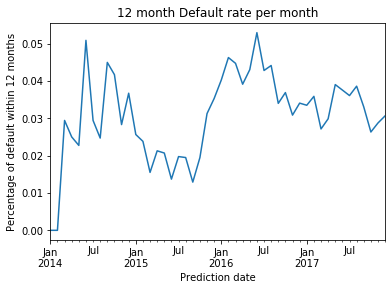

In [17]:
(labels_loan_and_month_level.groupby('prediction_date')['default_12mth']
                            .mean()
                            .sort_index()
                            .plot(title=f'{PREDICTION_WINDOW_LENGTH} month Default rate per month')
                            .set(xlabel='Prediction date', ylabel='Percentage of default within 12 months'));

# 3. Save

In [18]:
project.save_data('labels.csv', labels_loan_and_month_level.to_csv(index=False), overwrite=True)

{'file_name': 'data_asset/labels.csv',
 'message': 'File saved to project storage.',
 'asset_id': '9624984c-7775-4100-bce6-2002340354ce'}